# Working with new masks (if the masks and center.csv files are already saved to the local directory you can start from this point if not make them with the Mask Notebook)

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
centers_back = pd.read_csv('Centers_back.csv')
CB = centers_back.drop('Unnamed: 0',axis=1)
CB_array = CB.to_numpy()
centers_back = [(CB_array[0][i],CB_array[1][i]) for i in range(len(CB_array[0]))]

In [3]:
centers2 = pd.read_csv('Centers_front.csv')
CB = centers2.drop('Unnamed: 0',axis=1)
CB_array = CB.to_numpy()
centers = [(CB_array[0][i],CB_array[1][i]) for i in range(len(CB_array[0]))]

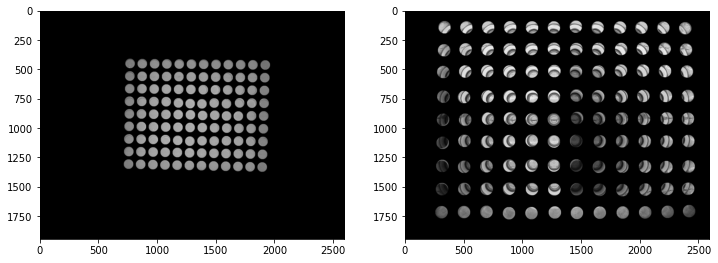

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import os 

fname = 'Plate_Image.jpg'
fname2 = 'Plate_back_image.jpg'
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12, 8))

mask_1 = rgb2gray(mpimg.imread(fname))
ax[0].imshow(mask_1, cmap='gray')

mask_2 = rgb2gray(mpimg.imread(fname2))
ax[1].imshow(mask_2, cmap='gray')

(108, 108)

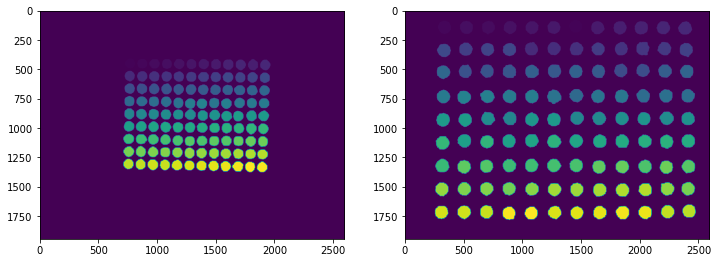

In [5]:
from skimage.measure import label, regionprops
from skimage.morphology import opening, disk

smask = opening(mask_1, disk(15)) # this seems to be needed to remove some noise if it doesnt pick up on all of the wells just change the disk value or remake the mask
smask2 = opening(mask_2,disk(10))
label_image, num = label(smask > 0, return_num=True)
label_image2, num2 = label(smask2 > 0 , return_num=True)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12, 8))
ax[0].imshow(label_image)
ax[1].imshow(label_image2)
(num,num2)

## Working with the labeled images

108


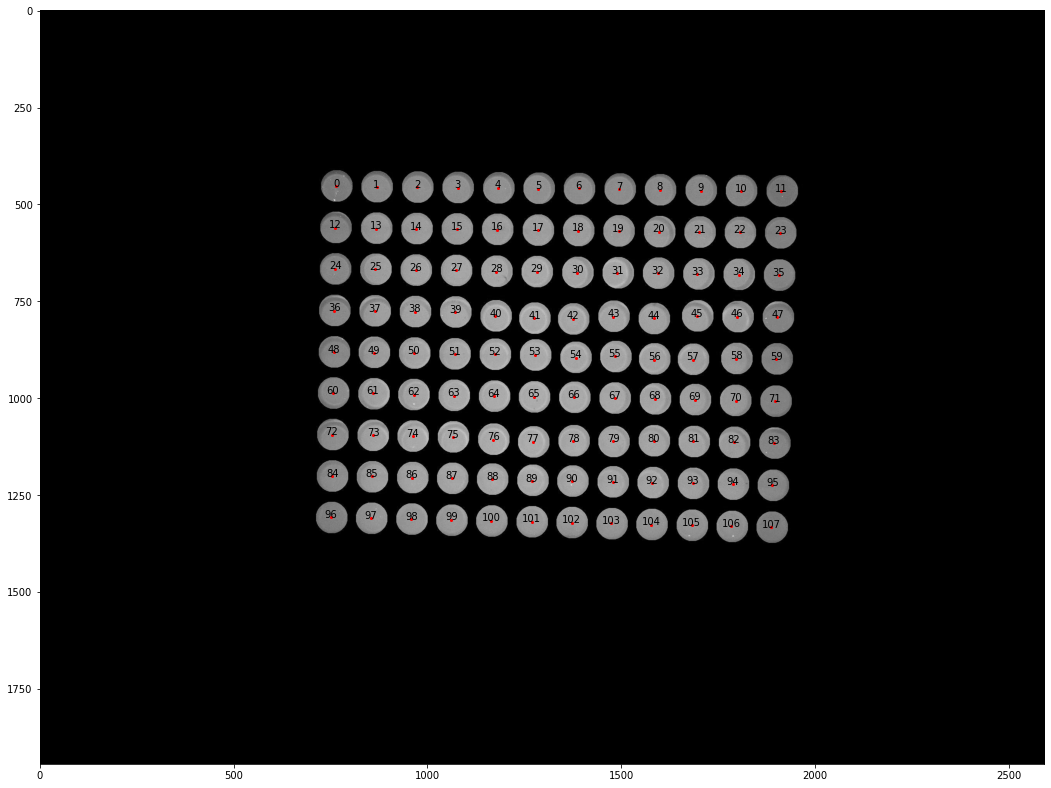

In [6]:
import numpy as np

regions = regionprops(label_image)
print(len(regions))
centroids = [(i, region.centroid) for i, region in enumerate(regions)]

# Sort the centroids by y
centroids = sorted(centroids, key=lambda x: x[1][0])

rows = np.split(np.array(centroids), 9)
# we sort each row on x
rows = [sorted(row, key=lambda x: x[1][1]) for row in rows]

wells = np.concatenate(rows)
indices = [x[0] for x in wells]
ordered_regions = [regions[i] for i in indices];

plt.figure(figsize=(18, 16))
plt.imshow(mask_1, cmap='gray')
for n, region in enumerate(ordered_regions):
    j, i = region.centroid
    plt.plot(i, j, 'ro', ms=2) # we plot these in the opposite order we read them.
    plt.text(i, j, f'{n}', ha='center')

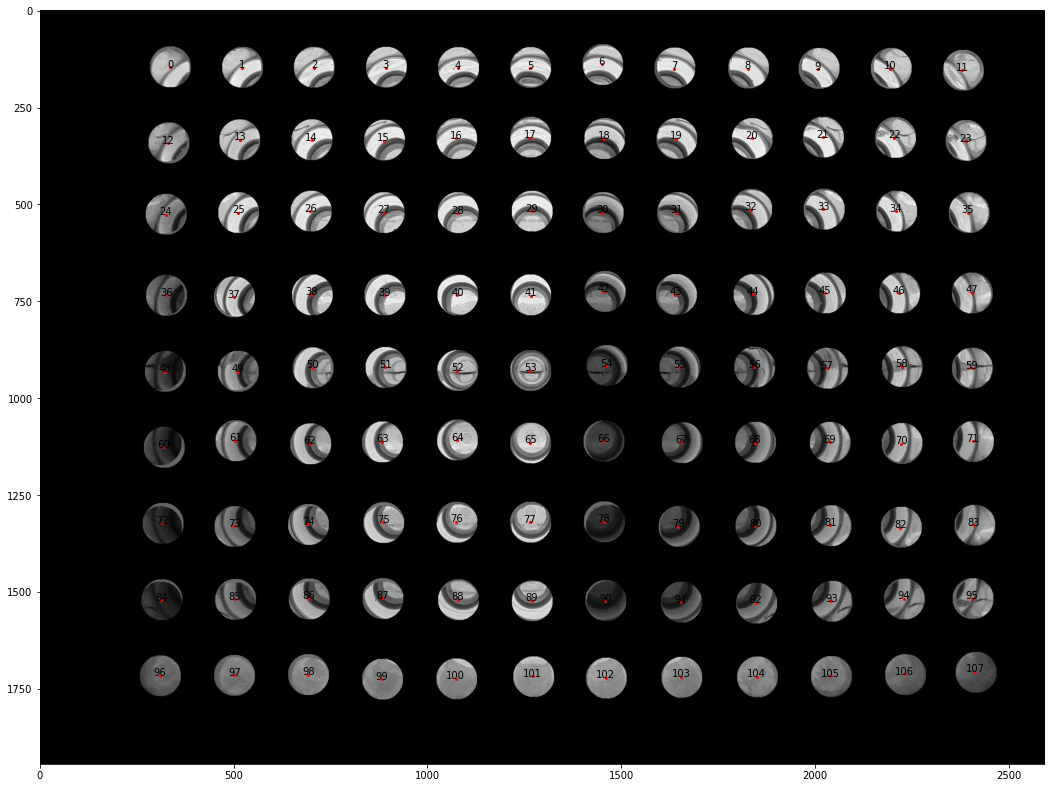

In [7]:
import numpy as np

regions2 = regionprops(label_image2)

centroids2 = [(i, region2.centroid) for i, region2 in enumerate(regions2)]

# Sort the centroids by y
centroids2 = sorted(centroids2, key=lambda x: x[1][0])

rows2 = np.split(np.array(centroids2), 9)
# we sort each row on x
rows2 = [sorted(row, key=lambda x: x[1][1]) for row in rows2]

wells2 = np.concatenate(rows2)
indices2 = [x[0] for x in wells2]
ordered_regions2 = [regions2[i] for i in indices2];
#print(indices2)
plt.figure(figsize=(18, 16))
plt.imshow(rgb2gray(mask_2), cmap='gray')
for n, region in enumerate(ordered_regions2):
    j, i = region.centroid
    plt.plot(i, j, 'ro', ms=2) # we plot these in the opposite order we read them.
    plt.text(i, j, f'{n}', ha='center')

### This is just a helper function to store the sorted file names for each of the images in a given directory

In [8]:
dir_under, = !find . -type d | grep Under
dir_over, = !find . -type d | grep Over

In [9]:
import os 

def switch_dir(directory):
    """" Input "Over", "Under" or "Main" to switch the working directory to the desired location. 
    If you are not in one of the specified paths in the Image Analysis folder it will tell you. """

    
    if os.getcwd().endswith('/Image_Analysis'):
        if directory == 'Main':
            os.chdir('.')
        elif directory == 'Over':
            os.chdir(dir_over)
        elif directory == 'Under':
            os.chdir(dir_under)
        else:
            print('The only options are Main, Over, and Under')
    elif os.getcwd().endswith(dir_over.split('.')[-1]):
        if directory == 'Main':
            os.chdir('..')
        elif directory == 'Over':
            os.chdir('.')
        elif directory == 'Under':
            os.chdir('.'+ dir_under)
        else:
            print('The only options are Main, Over, and Under')
    elif os.getcwd().endswith(dir_under.split('.')[-1]):
        if directory == 'Main':
            os.chdir('..')
        elif directory == 'Over':
            os.chdir('.' + dir_over)
        elif directory == 'Under':
            os.chdir('.')
        else:
            print('The only options are Main, Over, and Under')
    else:
        print('You do not seem to be in a recognized directory')

In [10]:
switch_dir('Over')
def search_util(root='.'):
    """Recursively find all files in a directory.
    root - This is the directory you would like to find the files in, defaults to cwd""" 
    files = []
    for r, d, f in os.walk(root):
        for file in f:
            if os.path.join(r, file).endswith('.jpg'):
                files += [os.path.join(r, file)]
    return sorted(files)
Over = search_util()

In [11]:
switch_dir('Under')
Under = search_util()

In [12]:
print(len(Over),len(Under))

122 122


In [13]:
import seaborn as sns

# Skip the Next Portion of the Code if all you need is the precipitate values

## Building an interactive tool for visualizing changes in individual wells

Collecting the RGB values from the bottom image of the plate as well as the change in darkness values from the top image

In [14]:
Well_Num = [54,55] # Well numbers you want to visualize (you can locate the well numbers on the images displayed above)

In [15]:
import skimage
import time 
start = time.time()
if isinstance(Well_Num,list):
    Red = np.zeros((len(Well_Num),len(Under)))
    Green = np.zeros((len(Well_Num),len(Under)))
    Blue = np.zeros((len(Well_Num),len(Under)))
    H2 = np.zeros((len(Well_Num),len(Over)))
    Time = []
    counter = 0
    for j in range(len(Well_Num)):
        Region = ordered_regions[Well_Num[j]]
        Region2 = ordered_regions2[Well_Num[j]]
        for i in range(len(Under)):
            switch_dir('Under')
            plate = mpimg.imread(Under[i]).copy()
            mask2 = np.ones(shape=plate.shape[0:2], dtype="bool") # create the mask image
            R = 56 - 3 # Radius of circles
            #i = 1

            for coor in centers_back:
                x = int(coor[0])
                y = int(coor[1])
                rr, cc = skimage.draw.circle(y, x, radius=R, shape=plate.shape[0:2])
                mask2[rr, cc] = False

            # Apply the mask
            plate[mask2] = 0
            back = plate
            pixels = back[Region2.slice]
            Red[j,i] = np.max(pixels[:,:,0])
            Green[j,i] = np.max(pixels[:,:,1])
            Blue[j,i] = np.max(pixels[:,:,2])
            if j == 0:
                Time.append(counter)
                counter += 10


        for i in range(len(Over)):
            switch_dir('Over')
            plate = mpimg.imread(Over[i]).copy()
            mask2 = np.ones(shape=plate.shape[0:2], dtype="bool") # create the mask image
            R = 56 - 15 # Radius of circles


            for coor in centers:
                x = int(coor[0])
                y = int(coor[1])
                rr, cc = skimage.draw.circle(y, x, radius=R, shape=plate.shape[0:2])
                mask2[rr, cc] = False

            # Apply the mask
            plate[mask2] = 0
            front = plate
            pixels = front[Region.slice]####################
            if i == 0:
                base_line = np.mean(pixels)
            H2[j,i] = np.mean(pixels)/base_line
    
else:
    Red = []
    Green = []
    Blue = []
    Time = []
    counter = 0
    
    Region = ordered_regions[Well_Num]
    Region2 = ordered_regions2[Well_Num]
    for i in range(len(Under)):
        switch_dir('Under')
        
        plate = mpimg.imread(Under[i]).copy()
        mask2 = np.ones(shape=plate.shape[0:2], dtype="bool") # create the mask image
        R = 56 - 3 # Radius of circles
        i = 1

        for coor in centers_back:
            x = int(coor[0])
            y = int(coor[1])
            rr, cc = skimage.draw.circle(y, x, radius=R, shape=plate.shape[0:2])
            i = 2
            mask2[rr, cc] = False

        # Apply the mask
        plate[mask2] = 0
        back = plate
        pixels = back[Region2.slice]####################
        Red.append(np.max(pixels[:,:,0]))
        Green.append(np.max(pixels[:,:,1]))
        Blue.append(np.max(pixels[:,:,2]))
        Time.append(counter)
        counter += 10

    H2 = []

    for i in range(len(Over)):
        switch_dir('Over')
        plate = mpimg.imread(Over[i]).copy()
        mask2 = np.ones(shape=plate.shape[0:2], dtype="bool") # create the mask image
        R = 56 - 15 # Radius of circles


        for coor in centers:
            x = int(coor[0])
            y = int(coor[1])
            rr, cc = skimage.draw.circle(y, x, radius=R, shape=plate.shape[0:2])
            mask2[rr, cc] = False

        # Apply the mask
        plate[mask2] = 0
        front = plate
        pixels = front[Region.slice]
        if i == 0:
            base_line = np.mean(pixels)
        H2.append(np.mean(pixels)/base_line)

print(time.time()-start)

122.96138000488281


**Below is the interactive tool the well number is inputed and then the graphs are built and the images can be scrolled through**

In [16]:
import os
from IPython.display import Image, display
from IPython.html.widgets import interact
from skimage.color import rgb2gray
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage 

def Plate_view(well_num,f1,f2,k):
    switch_dir('Over')
    front = rgb2gray(mpimg.imread(f1))
    image2 = front.copy() # Copying the original image of the plate

    mask = np.ones(shape=image2.shape[0:2], dtype="bool") # create the mask image
    R = 56 - 15 # Radius of circles
    i = 1
    
    for coor in centers:
        x = int(coor[0])
        y = int(coor[1])
        rr, cc = skimage.draw.circle(y, x, radius=R, shape=image2.shape[0:2])
        i = 2
        mask[rr, cc] = False

    # Apply the mask
    image2[mask] = 0
    front = image2
    switch_dir('Under')
    back = mpimg.imread(f2)
    image3 = back.copy() # Copying the original image of the plate

    mask2 = np.ones(shape=image3.shape[0:2], dtype="bool") # create the mask image
    R = 56 - 3 # Radius of circles
    i = 1

    for coor in centers_back:
        x = int(coor[0])
        y = int(coor[1])
        rr, cc = skimage.draw.circle(y, x, radius=R, shape=image3.shape[0:2])
        i = 2
        mask2[rr, cc] = False

    # Apply the mask
    image3[mask2] = 0
    back = image3
    if isinstance(well_num,list):
        sns.set_style("dark")
        fig, ax = plt.subplots(nrows=len(well_num),ncols=4,figsize=(13, 10))
        for i in range(len(well_num)):
            x1,y1,x2,y2 = ordered_regions[well_num[i]].bbox
            x12,y12,x22,y22 = ordered_regions2[well_num[i]].bbox

            pix = back[x12:x22,y12:y22]
            pix_front = front[x1:x2,y1:y2]
            
            ax[i,0].imshow(front[x1:x2,y1:y2], cmap='gray')
            ax[i,0].set_title(f'Front View for Well: {well_num[i]}')
            ax[i,2].imshow(back[x12:x22,y12:y22],cmap='gray')
            ax[i,2].set_title(f'Back View for Well: {well_num[i]}')
            ax[i,3].plot(Time,Red[i],'r--',Time,Green[i],'g--',Time,Blue[i],'b--',k*10,Red[i,k],'ko',k*10,Green[i,k],'ko',k*10,Blue[i,k],'ko')
            ax[i,3].set_title(f'Color Change for Well {well_num[i]}')
            ax[i,3].set_xlabel('Time (minutes)')
            
            ax[i,1].plot(Time,H2[i,:],'--',k*10,H2[i,k],'ko')
            ax[i,1].set_title(f'Change in Darkness for Well {well_num[i]}')
            ax[i,1].set_xlabel('Time (minutes)')
            ax[i,1].set_ylim([np.min(H2), np.max(H2)])
    else:
    
        x1,y1,x2,y2 = ordered_regions[well_num].bbox
        x12,y12,x22,y22 = ordered_regions2[well_num].bbox

        pix = back[x12:x22,y12:y22]
        pix_front = front[x1:x2,y1:y2]
        sns.set_style("dark")
        fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(12, 8))
        ax[0].imshow(front[x1:x2,y1:y2], cmap='gray')
        ax[0].set_title('Front View')
        ax[1].imshow(back[x12:x22,y12:y22],cmap='gray')
        ax[1].set_title('Back View')
        ax[2].plot(Time,Red,'r--',Time,Green,'g--',Time,Blue,'b--',k*10,Red[k],'ko',k*10,Green[k],'ko',k*10,Blue[k],'ko')
        ax[2].set_title('Color Change')
        ax[2].set_xlabel('Time (minutes)')
        ax[3].plot(Time,H2,'--',k*10,H2[k],'ko')
        ax[3].set_title('Change in Darkness')
        ax[3].set_xlabel('Time (minutes)')
        #ax[2].set_legend(['Red','Green','Blue'])
        
    print(f'Well number(s) {Well_Num}' + '\n' + f'Time = {k*10} minutes')

def loadimg(k):
    switch_dir('Over')
    f1 = Over[k]
    switch_dir('Under')
    f2 = Under[k]
    Plate_view(Well_Num,f1,f2,k)

interact(loadimg, k=(0, len(Over)-3))

interactive(children=(IntSlider(value=59, description='k', max=119), Output()), _dom_classes=('widget-interact…

<function __main__.loadimg(k)>

# Detecting Precipitate 

In [16]:
import torch 
import torch.nn as nn
from skimage.measure import label, regionprops
from skimage.morphology import opening, disk
import time

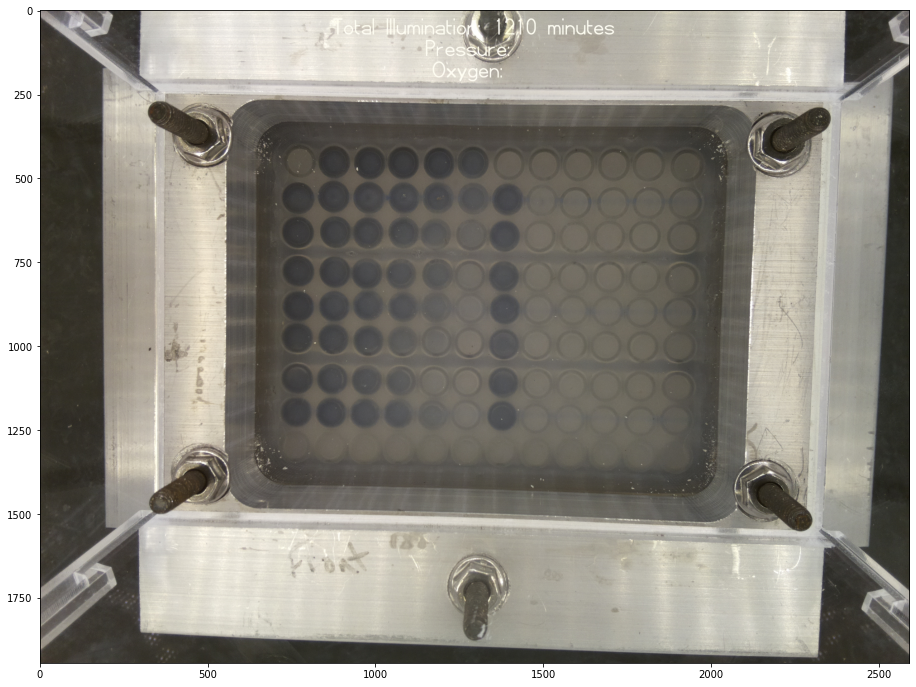

In [17]:
plt.figure(figsize=(16,12))
switch_dir('Over')
plt.imshow(mpimg.imread(Over[-1]),cmap='gray')

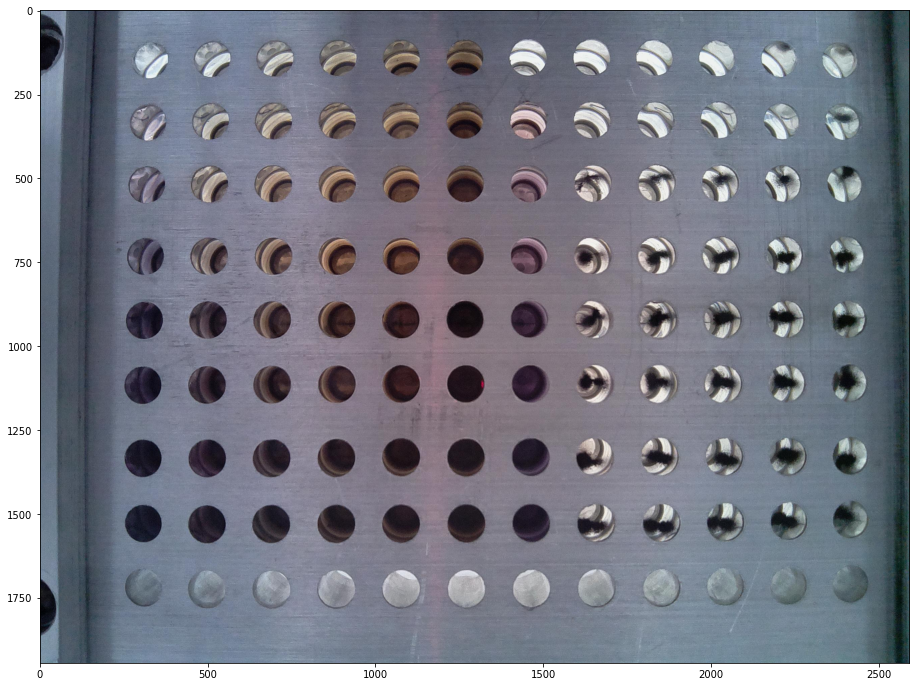

In [18]:
plt.figure(figsize=(16,12))
switch_dir('Under')
plt.imshow(mpimg.imread(Under[-1]),cmap='gray')

## Initializing pre-trained PyTorch CNN Model 

In [45]:
Model_type = 'Baseline'
class Normal_Block(nn.Module):
  def __init__(self, in_channels, out_channels):
        super(Normal_Block, self).__init__()

        self.block1 = nn.Sequential(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
            #nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size = 3,stride=1,padding=1,bias=False),
            #nn.BatchNorm2d(out_channels),
            #nn.ReLU())
        
        self.shortcut = nn.Sequential( 
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride =1, padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
                                )
        
  def forward(self, x):
      output = self.block1(x)
      res = self.shortcut(x)
      output += res # self.shortcut(x)
      return output

class Network(nn.Module): # [3,4,6,3] first resNet use block 3 times then the second use it 4 times
    def __init__(self, num_feats, num_classes):
        super(Network, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=num_feats,out_channels=64,kernel_size = 7,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
                                    )

        # LINEAR LAYER (For Classes)
        self.linear_layer_classes = nn.Linear(204800,num_classes,bias=False)


    def forward(self, x, evalMode=False):
        # Baseline layers 
        output = self.layers(x)
        output = output.reshape(output.shape[0],-1)
        label_output = self.linear_layer_classes(output)
        label_output = label_output/torch.norm(self.linear_layer_classes.weight, dim=1)
        
        return label_output

In [47]:
switch_dir('Main')
model2 = Network(3,1)
if torch.cuda.is_available():
    model2.load_state_dict(torch.load('Model_Classification_GPU_430_epochs.pt'));
    model2.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model2.to(device).float()
else:
    model2.load_state_dict(torch.load('Model_Classification_GPU_430_epochs.pt',map_location=torch.device('cpu')));
    model2.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model2.to(device).float()

## Using the CNN Model to Predict the Wells with Precipitate and Skimage to find the Area

In [48]:
# Converting the Images to Tensors

Images = np.zeros((len(ordered_regions2),80,80,3))
switch_dir('Under')

for i,region in enumerate(ordered_regions2):
    X,Y = region.coords[:,0],region.coords[:,1]
    back = mpimg.imread(Under[-1]).copy()[region.slice][:80,:80,:]
    Images[i,:] = back

Images=torch.tensor(Images).to(device).float()

3.5933549404144287


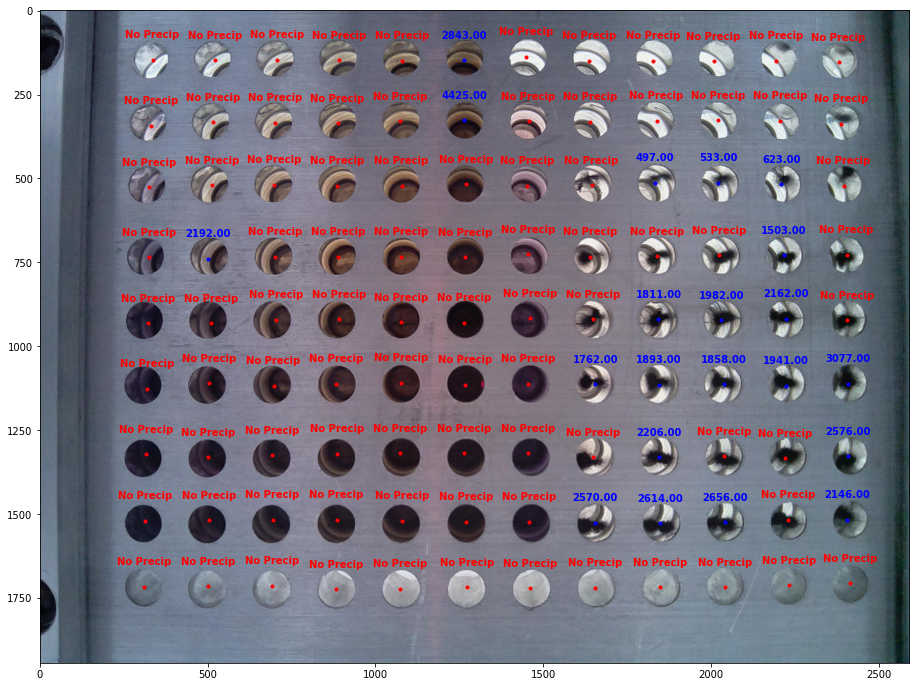

In [49]:
beggining_ending = [0,len(Over)-1]
start = time.time()
circle_mean=[]
box_mean=[]
well_list = []
def Find_Precipitate_Features(Under_dir):
    precip = []
    for j,region in enumerate(ordered_regions2):
        region2 = ordered_regions2[j]
        model2.eval()
        
        Prediction = torch.round(torch.sigmoid(model2(Images[j].unsqueeze(0).permute(0,3,1,2).float())))
        if Prediction == 0:
            well_list.append(f'Well {j}')
            precip.append(0)
            continue   
            
        
        def rgb2gray(rgb):
            return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
        switch_dir('Under')
        back = mpimg.imread(Under[-1]).copy()
        # Finding the precipitate 
        Gray_well = rgb2gray(back[region.slice])
        well_num = j
        Gray_well[Gray_well==0] = 255
        smask = opening(Gray_well, disk(5)) # this seems to be needed to remove some noise
        label_image = label(50>smask)
        if len(regionprops(label_image))==0:
            well_list.append(f'Well {well_num}')
            precip.append(0)
            continue
        region_well = regionprops(label_image)
        if len(region_well)>1:
            out = 0
            for i in range(len(region_well)):
                out += region_well[i].area
        else: 
            out = region_well[0].area
        
        well_list.append(f'Well {well_num}')
        precip.append(out)
    
    df_precip_area = pd.DataFrame({'Precipitate Area (pixels)':precip},index=well_list)
    return df_precip_area

df = Find_Precipitate_Features(Under) # This dataframe holds the precipitate area found in each well 
print(time.time()-start)

# Ploting the Results

plt.figure(figsize=(16,12))
switch_dir('Under')
mask2 = mpimg.imread(Under[-1])
plt.imshow(mask2)
for n, region in enumerate(ordered_regions2):
    precip = df.iloc[n][0]
    j, i = region.centroid
    if precip > 0:
        plt.plot(i, j, 'bo', ms=3) # we plot these in the opposite order we read them.
        plt.text(i, j-60, f'{precip:.2f}', ha='center',va='bottom',fontweight='bold',c='b')
    else:
        plt.plot(i, j, 'ro', ms=3) # we plot these in the opposite order we read them.
        plt.text(i, j-60, f'No Precip', ha='center',va='bottom',fontweight='bold',c='r')

In [38]:
len(df)

107

# Building and Training the Model

In [35]:
Images.shape

(108, 80, 80, 3)

In [39]:
Images = torch.Tensor(Images)

In [40]:
Wells_with_precip = np.array([23,31,32,33,34,35,43,44,45,46,47,55,56,57,58,59,67,68,69,70,71,79,80,81,82,83,91,92,93,94,95])
Targets = np.array([0 if x not in Wells_with_precip else 1 for x in range(108)])

In [41]:
Targets = torch.Tensor(Targets)
Targets.shape

torch.Size([108])

In [44]:
from __future__ import print_function, division
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class My_Dataset(Dataset):
    
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        
        X =  self.X[index]
        Y = self.Y[index].long()
        return X,Y

In [45]:
Dataset_binary_label = My_Dataset(Images,Targets)
dataloader = DataLoader(Dataset_binary_label, batch_size=4,pin_memory=True,
                        shuffle=True, num_workers=6)

## Baseline CNN Model 

In [ ]:
Model_type = 'Baseline'
import torch.nn as nn
class Normal_Block(nn.Module):
  def __init__(self, in_channels, out_channels):
        super(Normal_Block, self).__init__()

        self.block1 = nn.Sequential(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
            #nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size = 3,stride=1,padding=1,bias=False),
            #nn.BatchNorm2d(out_channels),
            #nn.ReLU())
        
        self.shortcut = nn.Sequential( 
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride =1, padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
                                )
        
  def forward(self, x):
      output = self.block1(x)
      res = self.shortcut(x)
      output += res # self.shortcut(x)
      return output

class Network(nn.Module): # [3,4,6,3] first resNet use block 3 times then the second use it 4 times
    def __init__(self, num_feats, num_classes):
        super(Network, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=num_feats,out_channels=64,kernel_size = 7,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size = 3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
                                    )

        # LINEAR LAYER (For Classes)
        self.linear_layer_classes = nn.Linear(204800,num_classes,bias=False)


    def forward(self, x, evalMode=False):
        # Baseline layers 
        output = self.layers(x)
        output = output.reshape(output.shape[0],-1)
        label_output = self.linear_layer_classes(output)
        label_output = label_output/torch.norm(self.linear_layer_classes.weight, dim=1)
        
        return label_output

In [54]:
switch_dir('Main')
model2 = Network(3,1).float()
model2.load_state_dict(torch.load('Model_Classification_GPU_430_epochs.pt'));
model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

Network(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.3, inplace=False)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): BatchNorm2d(128,

In [51]:
import torch
criterion = nn.BCEWithLogitsLoss()
optimizer_model = torch.optim.Adam(Net.parameters(),lr=1e-4)
Net.train()
Losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_model, mode='min', factor=0.05, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

for epoch in range(1000):
    
    for batch_num,(img,label) in enumerate(dataloader):
        img,label = img.to(device),label.to(device)
        optimizer_model.zero_grad()
        preds = Net(img.permute(0,3,1,2).float())
        loss = criterion(preds, label.unsqueeze(1).float())
        loss.backward()
        Losses.append(loss.item())
        optimizer_model.step()
        
    if epoch % 10 == 0:
        print(f'\n Epoch: {epoch}, \n Current Loss: {np.mean(Losses)}, \n Current prediction probabilities {torch.sigmoid(preds)} vs actual {label}')
        scheduler.step(np.mean(Losses))
    Losses = []


 Epoch: 0, 
 Current Loss: 1.0542889006987766, 
 Current prediction probabilities tensor([[0.9998],
        [0.0897],
        [0.9997],
        [0.1402]], device='cuda:0', grad_fn=<SigmoidBackward>) vs actual tensor([1, 0, 1, 0], device='cuda:0')

 Epoch: 10, 
 Current Loss: 0.0018999926585281544, 
 Current prediction probabilities tensor([[2.4383e-04],
        [9.9808e-01],
        [1.5595e-03],
        [9.8884e-01]], device='cuda:0', grad_fn=<SigmoidBackward>) vs actual tensor([0, 1, 0, 1], device='cuda:0')

 Epoch: 20, 
 Current Loss: 0.20374856937121, 
 Current prediction probabilities tensor([[9.9999e-01],
        [1.0023e-05],
        [5.0808e-06],
        [2.1043e-05]], device='cuda:0', grad_fn=<SigmoidBackward>) vs actual tensor([1, 0, 0, 0], device='cuda:0')

 Epoch: 30, 
 Current Loss: 0.014725501373902716, 
 Current prediction probabilities tensor([[6.5870e-05],
        [5.6113e-08],
        [2.6728e-05],
        [5.7239e-07]], device='cuda:0', grad_fn=<SigmoidBackward>) vs

KeyboardInterrupt: 

In [52]:
torch.save(Net.state_dict(), 'Model_Classification_GPU_430_epochs.pt')

In [48]:
import torchvision
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Net = Network(3,1)
Net.to(device)
Net = Net.float()

# Testing some Images

The model predicts there is not precipitate in this well


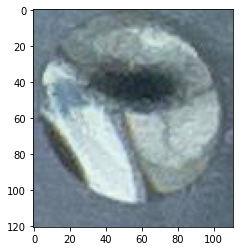

In [44]:
Test_image = 23

model2.eval()
Prediction = torch.sigmoid(model2(Images[Test_image].unsqueeze(0).permute(0,3,1,2).float()))
Prediction = torch.round(Prediction)
if Prediction == 0:
    print(f'The model predicts there is not precipitate in this well')
else:
    print(f'The model predicts there is precipitate in this well')
plt.imshow(mpimg.imread(Under[-1]).copy()[ordered_regions2[Test_image].slice])